## Requirements

### Imports

In [2]:
import os
import shutil
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.models import AlexNet_Weights
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
from torch.utils.tensorboard import SummaryWriter

In [3]:
torch.manual_seed(42)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Paths

In [5]:
src_folder = Path.cwd()
root_folder = src_folder.parent
dataset_folder = os.path.join(root_folder, 'dataset')
models_folder = os.path.join(root_folder, 'models')

baseline_folder = os.path.join(models_folder, 'baselines')
result_folder = os.path.join(baseline_folder, 'results')

PREPROCESSED_DIR = os.path.join(dataset_folder, 'preprocessed')
CSV_PATH = os.path.join(dataset_folder, 'csv_mappings', 'train.csv')

## Config

In [6]:
BATCH_SIZE = 32
NUM_CLASSES = 10 
EPOCHS = 20
PATIENCE = 3
LEARNING_RATE = 0.0001

## Data Preperation

### Mushroom Dataset

In [7]:
class MushroomDataset(Dataset):
    def __init__(self, preprocessed_dir, csv_path, transform=None):
        self.preprocessed_dir = preprocessed_dir  
        self.csv_path = csv_path  
        self.transform = transform  
        self.csv_data = pd.read_csv(csv_path)
        
        # Images and Labels
        self.image_ids = self.csv_data['Image'].values  
        self.labels = self.csv_data['Mushroom'].values 
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        label = self.labels[idx]

        image_id_str = str(image_id).zfill(5)  # Pad for filename
        
        # Load .pt files
        image_path = os.path.join(self.preprocessed_dir, f"{image_id_str}.pt")
        image = torch.load(image_path)  
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


### Prepare data

In [8]:
dataset = MushroomDataset(PREPROCESSED_DIR, CSV_PATH)
indices = list(range(len(dataset)))

### Split data

In [9]:
train_indices, temp_indices = train_test_split(indices, test_size=0.3, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

In [10]:
train_subset = torch.utils.data.Subset(dataset, train_indices)
val_subset = torch.utils.data.Subset(dataset, val_indices)
test_subset = torch.utils.data.Subset(dataset, test_indices)

### Dataloaders

In [11]:
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

## Train & Test functions

In [12]:
def save_model(model, optimizer, epoch, loss, accuracy, file_path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy,
    }

    torch.save(checkpoint, file_path)
    print(f"Model saved to {file_path}")

In [13]:
def train_on_epoch(model, train_loader, criterion, optimizer, device, epoch, writer, scheduler):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    for batch_idx, data in enumerate(tqdm(train_loader, desc="[Train]")):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Log loss and accuracy per batch to TensorBoard
        batch_accuracy = 100.0 * correct / total
        writer.add_scalar('Train/Loss', loss.item(), epoch * len(train_loader) + batch_idx)
        writer.add_scalar('Train/Accuracy', batch_accuracy, epoch * len(train_loader) + batch_idx)

    train_accuracy = 100.0 * correct / total
    avg_train_loss = train_loss / len(train_loader)

    # Log the learning rate
    for param_group in optimizer.param_groups:
        writer.add_scalar('Train/Learning Rate', param_group['lr'], epoch)

    # Step the scheduler
    if scheduler:
        scheduler.step()

    return avg_train_loss, train_accuracy

In [14]:
def validate_on_epoch(model, val_loader, criterion, optimizer, device, epoch, writer, best_val_loss, patience, epochs_no_improve, save_path):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, data in enumerate(tqdm(val_loader, desc="[Val]")):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Log loss and accuracy per batch to TensorBoard
            batch_accuracy = 100.0 * correct / total
            writer.add_scalar('Validation/Loss', loss.item(), epoch * len(val_loader) + batch_idx)
            writer.add_scalar('Validation/Accuracy', batch_accuracy, epoch * len(val_loader) + batch_idx)

    val_accuracy = 100.0 * correct / total
    avg_val_loss = val_loss / len(val_loader)

    # Early stopping 
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        save_model(model, optimizer, epoch, avg_val_loss, val_accuracy, save_path)
        print(f"Model saved to {save_path}")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        return best_val_loss, epochs_no_improve, True, val_accuracy 

    return best_val_loss, epochs_no_improve, False, val_accuracy

In [15]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs, device, writer, scheduler, patience, save_path):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        # Train
        train_loss, train_accuracy = train_on_epoch(model, train_loader, criterion, optimizer, device, epoch, writer, scheduler)
        print(f"Train Loss = {train_loss:.4f}, Train Acc = {train_accuracy:.2f}%")

        # Validate
        best_val_loss, epochs_no_improve, early_stop, val_accuracy = validate_on_epoch(
            model, val_loader, criterion, optimizer, device, epoch, writer, best_val_loss, patience, epochs_no_improve, save_path
        )
        print(f"Val Loss = {best_val_loss:.4f}, Val Acc = {val_accuracy:.2f}%")

        if early_stop:
            break  

    return model

In [16]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in tqdm(test_loader, desc="[Test]"):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Store preds and labels for plots
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_accuracy = 100.0 * correct / total
    avg_test_loss = test_loss / len(test_loader)

    print(f"Test Loss = {avg_test_loss:.4f}")
    print(f"Test Accuracy = {test_accuracy:.2f}%")
    
    return avg_test_loss, test_accuracy, all_labels, all_predictions


In [17]:
def plot_confusion_matrix(all_labels, all_predictions, num_classes, save_path=None):
    conf_matrix = confusion_matrix(all_labels, all_predictions, labels=np.arange(num_classes))
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
        print(f"Confusion matrix saved to {save_path}")

    plt.show()


In [18]:
def per_class_accuracy(all_labels, all_predictions, num_classes):
    class_accuracies = []
    
    for i in range(num_classes):
        class_indices = [j for j, label in enumerate(all_labels) if label == i]
        class_predictions = [all_predictions[j] for j in class_indices]
        class_labels = [all_labels[j] for j in class_indices]
        
        class_accuracy = accuracy_score(class_labels, class_predictions)
        class_accuracies.append(class_accuracy)
        print(f"Accuracy class {i}: {class_accuracy:.4f}")
    
    return class_accuracies


In [19]:
def display_classification_report_as_dataframe(all_labels, all_predictions):
    report_dict = classification_report(all_labels, all_predictions, target_names=[str(i) for i in range(len(set(all_labels)))], output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    display(report_df)
    return report_df

# Training

## Pretrained Models

### Pretrained AlexNet

In [20]:
model_alexnet = models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)
model_alexnet.classifier[6] = nn.Linear(model_alexnet.classifier[6].in_features, NUM_CLASSES)
model_alexnet = model_alexnet.to(device)

optimizer_alexnet = optim.AdamW(model_alexnet.parameters(), lr=LEARNING_RATE)
save_path_alexnet = os.path.join(result_folder, "model_alexnet.pth")

### Pretrained ResNet

In [21]:
model_resnet = models.resnet50(weights='IMAGENET1K_V1') 
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, NUM_CLASSES)  
model_resnet = model_resnet.to(device)

optimizer_resnet = optim.AdamW(model_resnet.parameters(), lr=LEARNING_RATE)
save_path_resnet = os.path.join(result_folder, "model_resnet.pth")

#### Pretrained VGG16

In [22]:
model_vgg16 = models.vgg16(weights='IMAGENET1K_V1')
model_vgg16.classifier[6] = nn.Linear(model_vgg16.classifier[6].in_features, NUM_CLASSES)
model_vgg16 = model_vgg16.to(device)

optimizer_vgg16 = optim.AdamW(model_vgg16.parameters(), lr=LEARNING_RATE)
save_path_vgg16 = os.path.join(result_folder, "model_vgg16.pth")

#### Pretrained DenseNet

In [23]:
model_densenet = models.densenet121(weights='IMAGENET1K_V1')
model_densenet.classifier = nn.Linear(model_densenet.classifier.in_features, NUM_CLASSES)
model_densenet = model_densenet.to(device)

optimizer_densenet = optim.AdamW(model_densenet.parameters(), lr=LEARNING_RATE)
save_path_densenet = os.path.join(result_folder, "model_densenet.pth")

#### Pretrained EfficientNet

In [24]:
model_efficientnet = models.efficientnet_b0(weights='IMAGENET1K_V1')
model_efficientnet.classifier[1] = nn.Linear(model_efficientnet.classifier[1].in_features, NUM_CLASSES)
model_efficientnet = model_efficientnet.to(device)

optimizer_efficientnet = optim.AdamW(model_efficientnet.parameters(), lr=LEARNING_RATE)
save_path_efficientnet = os.path.join(result_folder, "model_efficientnet.pth")

#### Setter for model 

In [29]:
def set_model_for_training(model_type):
    base_log_path = os.path.join(baseline_folder, model_type, 'log')
    base_result_path = os.path.join(baseline_folder, model_type, 'results')

    if os.path.exists(base_log_path):
        shutil.rmtree(base_log_path)
    os.makedirs(base_log_path, exist_ok=True)
    os.makedirs(base_result_path, exist_ok=True)

    if model_type == 'alexnet':
        model = model_alexnet
        optimizer = optimizer_alexnet
        save_path = os.path.join(base_result_path, "model_alexnet.pth")

    elif model_type == 'resnet':
        model = model_resnet
        optimizer = optimizer_resnet
        save_path = os.path.join(base_result_path, "model_resnet.pth")

    elif model_type == 'vgg16':
        model = model_vgg16
        optimizer = optimizer_vgg16
        save_path = os.path.join(base_result_path, "model_vgg16.pth")

    elif model_type == 'densenet':
        model = model_densenet
        optimizer = optimizer_densenet
        save_path = os.path.join(base_result_path, "model_densenet.pth")

    elif model_type == 'efficientnet':
        model = model_efficientnet
        optimizer = optimizer_efficientnet
        save_path = os.path.join(base_result_path, "model_efficientnet.pth")

    else:
        raise ValueError(f"Unsupported model type")
    
    writer = SummaryWriter(log_dir=base_log_path)
    print(model)
    
    return model, optimizer, save_path, writer


## Training

In [36]:
model_type = 'efficientnet' # alexnet # resnet # vgg16 # densenet # efficientnet

In [37]:
model, optimizer, save_path, writer = set_model_for_training(model_type)
criterion = nn.CrossEntropyLoss()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [64]:
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)

In [28]:
model = train_and_validate(model, 
                           train_loader, 
                           val_loader, 
                           criterion, 
                           optimizer, 
                           epochs=EPOCHS, 
                           device=device, 
                           writer=writer, 
                           scheduler=scheduler, 
                           patience=PATIENCE, 
                           save_path=save_path)
writer.close()


Epoch 1/20


[Train]:   0%|          | 0/52 [00:00<?, ?it/s]C:\Users\Micha\AppData\Local\Temp\ipykernel_46560\2605163665.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torc

Train Loss = 2.0501, Train Acc = 36.01%


[Val]: 100%|██████████| 12/12 [00:00<00:00, 29.84it/s]


Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Val Loss = 1.6444, Val Acc = 61.97%

Epoch 2/20


[Train]: 100%|██████████| 52/52 [00:03<00:00, 15.09it/s]


Train Loss = 1.2615, Train Acc = 72.99%


[Val]: 100%|██████████| 12/12 [00:00<00:00, 30.74it/s]


Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Val Loss = 0.9116, Val Acc = 77.46%

Epoch 3/20


[Train]: 100%|██████████| 52/52 [00:03<00:00, 14.32it/s]


Train Loss = 0.7606, Train Acc = 83.63%


[Val]: 100%|██████████| 12/12 [00:00<00:00, 32.42it/s]


Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Val Loss = 0.7432, Val Acc = 81.13%

Epoch 4/20


[Train]: 100%|██████████| 52/52 [00:03<00:00, 14.88it/s]


Train Loss = 0.5674, Train Acc = 87.25%


[Val]: 100%|██████████| 12/12 [00:00<00:00, 32.95it/s]


Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Val Loss = 0.6130, Val Acc = 83.38%

Epoch 5/20


[Train]: 100%|██████████| 52/52 [00:03<00:00, 14.83it/s]


Train Loss = 0.4393, Train Acc = 90.82%


[Val]: 100%|██████████| 12/12 [00:00<00:00, 32.71it/s]


Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Val Loss = 0.5754, Val Acc = 83.94%

Epoch 6/20


[Train]: 100%|██████████| 52/52 [00:03<00:00, 15.51it/s]


Train Loss = 0.3876, Train Acc = 92.21%


[Val]: 100%|██████████| 12/12 [00:00<00:00, 31.98it/s]


Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Val Loss = 0.5428, Val Acc = 84.79%

Epoch 7/20


[Train]: 100%|██████████| 52/52 [00:03<00:00, 15.81it/s]


Train Loss = 0.3337, Train Acc = 93.84%


[Val]: 100%|██████████| 12/12 [00:00<00:00, 34.60it/s]


Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Val Loss = 0.5224, Val Acc = 84.79%

Epoch 8/20


[Train]: 100%|██████████| 52/52 [00:03<00:00, 15.68it/s]


Train Loss = 0.2990, Train Acc = 94.26%


[Val]: 100%|██████████| 12/12 [00:00<00:00, 33.33it/s]


Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Val Loss = 0.5047, Val Acc = 84.23%

Epoch 9/20


[Train]: 100%|██████████| 52/52 [00:03<00:00, 15.57it/s]


Train Loss = 0.2908, Train Acc = 95.23%


[Val]: 100%|██████████| 12/12 [00:00<00:00, 32.52it/s]


Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Val Loss = 0.4923, Val Acc = 85.35%

Epoch 10/20


[Train]: 100%|██████████| 52/52 [00:03<00:00, 15.30it/s]


Train Loss = 0.2777, Train Acc = 95.17%


[Val]: 100%|██████████| 12/12 [00:00<00:00, 34.78it/s]


Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Val Loss = 0.4913, Val Acc = 86.20%

Epoch 11/20


[Train]: 100%|██████████| 52/52 [00:03<00:00, 15.26it/s]


Train Loss = 0.2664, Train Acc = 95.53%


[Val]: 100%|██████████| 12/12 [00:00<00:00, 33.79it/s]


Val Loss = 0.4913, Val Acc = 85.92%

Epoch 12/20


[Train]: 100%|██████████| 52/52 [00:03<00:00, 15.26it/s]


Train Loss = 0.2717, Train Acc = 94.92%


[Val]: 100%|██████████| 12/12 [00:00<00:00, 33.89it/s]


Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Val Loss = 0.4835, Val Acc = 85.63%

Epoch 13/20


[Train]: 100%|██████████| 52/52 [00:03<00:00, 15.40it/s]


Train Loss = 0.2666, Train Acc = 95.59%


[Val]: 100%|██████████| 12/12 [00:00<00:00, 34.77it/s]


Val Loss = 0.4835, Val Acc = 85.07%

Epoch 14/20


[Train]: 100%|██████████| 52/52 [00:03<00:00, 15.50it/s]


Train Loss = 0.2560, Train Acc = 95.59%


[Val]: 100%|██████████| 12/12 [00:00<00:00, 32.89it/s]


Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Model saved to g:\Benutzer\X_Ichigo_X\Dokumente\FH_Master\Ki_labor\Mushroom\models\baselines\efficientnet\results\model_efficientnet.pth
Val Loss = 0.4787, Val Acc = 85.92%

Epoch 15/20


[Train]: 100%|██████████| 52/52 [00:03<00:00, 15.66it/s]


Train Loss = 0.2653, Train Acc = 95.29%


[Val]: 100%|██████████| 12/12 [00:00<00:00, 34.66it/s]


Val Loss = 0.4787, Val Acc = 86.20%

Epoch 16/20


[Train]: 100%|██████████| 52/52 [00:03<00:00, 15.27it/s]


Train Loss = 0.2732, Train Acc = 94.38%


[Val]: 100%|██████████| 12/12 [00:00<00:00, 35.19it/s]


Val Loss = 0.4787, Val Acc = 85.63%

Epoch 17/20


[Train]: 100%|██████████| 52/52 [00:03<00:00, 15.26it/s]


Train Loss = 0.2560, Train Acc = 94.86%


[Val]: 100%|██████████| 12/12 [00:00<00:00, 33.14it/s]

Early stopping triggered at epoch 17
Val Loss = 0.4787, Val Acc = 85.35%


## Evaluation

In [65]:
evaluation_results_path = os.path.join(os.path.dirname(save_path), "evaluation_results.txt")
confusion_matrix_path = os.path.join(os.path.dirname(save_path), "plot_confusion_matrix.png")

In [66]:
avg_test_loss, test_accuracy, all_labels, all_predictions = evaluate_model(model, test_loader, criterion, device)

[Test]:   0%|          | 0/12 [00:00<?, ?it/s]C:\Users\ilian\AppData\Local\Temp\ipykernel_20768\2605163665.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image = torch

Test Loss = 2.4103
Test Accuracy = 11.83%


In [67]:
per_class_acc = per_class_accuracy(all_labels, all_predictions, NUM_CLASSES)

Accuracy class 0: 0.0000
Accuracy class 1: 0.0213
Accuracy class 2: 0.0000
Accuracy class 3: 0.6471
Accuracy class 4: 0.0286
Accuracy class 5: 0.1500
Accuracy class 6: 0.0000
Accuracy class 7: 0.2857
Accuracy class 8: 0.0741
Accuracy class 9: 0.0000


In [68]:
report_df = display_classification_report_as_dataframe(all_labels, all_predictions)

c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,37.00000
1,0.083333,0.021277,0.033898,47.00000
2,0.000000,0.000000,0.000000,43.00000
3,0.156028,0.647059,0.251429,34.00000
4,0.040000,0.028571,0.033333,35.00000
5,0.214286,0.150000,0.176471,40.00000
6,0.000000,0.000000,0.000000,30.00000
7,0.090909,0.285714,0.137931,35.00000
8,0.090909,0.074074,0.081633,27.00000
9,0.000000,0.000000,0.000000,27.00000


Confusion matrix saved to c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\models\baselines\densenet\results\plot_confusion_matrix.png


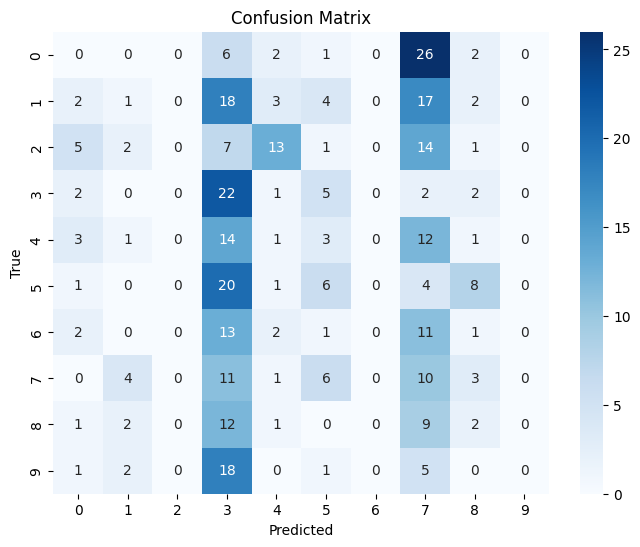

In [69]:
plot_confusion_matrix(all_labels, all_predictions, NUM_CLASSES, save_path=confusion_matrix_path)

In [70]:
with open(evaluation_results_path, 'w') as f:
    f.write(f"Test Loss = {avg_test_loss:.4f}\n")
    f.write(f"Test Accuracy = {test_accuracy:.2f}%\n")
    f.write("\nClassification Report:\n")
    f.write(classification_report(all_labels, all_predictions, target_names=[str(i) for i in range(NUM_CLASSES)]))
    f.write("\nPer-Class Accuracy:\n")
    for i, acc in enumerate(per_class_acc):
        f.write(f"Class {i}: {acc:.2f}\n")

c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no